<center><h1>
تمرین عملی دوم
</h1></center>

<div dir="rtl">
در این تمرین می‌خواهیم یک بازی ساده و تاثیر تکرار بازی را با هم بررسی کنیم. در هر مرحله کافی‌ست توابع معرفی‌شده را پیاده‌سازی کنید.

لطفا برای اطمینان از محل اجرا، قطعه‌کد پایین را اجرا کنید.

ایمان محمدی

99102207

لینک کولب: https://colab.research.google.com/drive/1Gn-fBwRVpQ3wusd4QDFpvYiPeFx2BHJI?usp=sharing
</div>

In [50]:
from abc import abstractmethod
from dataclasses import dataclass, field
from random import choices
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np


Offer = Tuple[int, int]


class Strategy:
    @abstractmethod
    def generate_offer(self, **kwargs) -> Offer:
        ...

    @abstractmethod
    def receive_offer(self, **kwargs) -> bool:
        ...

    def start_round(self):
        ...

    @property
    def name(self):
        return self.__class__.__name__


@dataclass
class Player:
    idx: int
    strategy: Strategy
    asset: int = field(default=1)

    def generate_offer(self, *args, **kwargs) -> Offer:
        return self.strategy.generate_offer(*args, your_idx=self.idx, **kwargs)

    def receive_offer(self, *args, **kwargs) -> bool:
        return self.strategy.receive_offer(*args, your_idx=self.idx, **kwargs)

    def start_round(self):
        self.strategy.start_round()

    @property
    def name(self):
        return self.strategy.__class__.__name__


@dataclass
class GameConfiguration:
    strategies: List[Strategy]  # Strategy for each player
    offers: int = field(default=1)  # Number of possible offers in each game
    player2_offers: bool = field(default=False)  # If False, only player1 places offers
    value: int = field(default=100)
    show_history: bool = field(
        default=False
    )  # If True, players will have access to past offers and their results
    games: int = field(default=1)  # Number of games held randomly between players


class GameRunner:
    """
    Instantiates a game between two players with using a configuration setting
    parameters for the game.
    """

    config: GameConfiguration
    players: List[Player]
    round_results: Dict[str, List[int]]

    def __init__(self, config: GameConfiguration):
        self.config = config
        self.players = [
            Player(idx, strategy) for idx, strategy in enumerate(self.config.strategies)
        ]
        self.round_results = {}
        self.games = []

    def play(self, players: Tuple[Player, Player]) -> Tuple[int, int]:
        """
        Runs the game.

        Returns A tuple representing the final reward of player1 and player2 respectively
        """

        def validate_offer(offer: Offer) -> bool:
            return (
                offer[0] >= 0
                and offer[1] >= 0
                and offer[0] + offer[1] == self.config.value
            )

        for player in players:
            player.start_round()
        offers = []
        for turn in range(self.config.offers):
            giver_idx = (turn % 2) * self.config.player2_offers
            offer = players[giver_idx].generate_offer(
                value=self.config.value,
                previous_games=self.games,
                receiver_idx=players[1 - giver_idx].idx,
            )
            offers.append(offer)
            assert validate_offer(offer)
            accepted = players[1 - giver_idx].receive_offer(
                offer=offer,
                previous_games=self.games,
                giver_idx=players[giver_idx].idx,
            )
            self.record_game(
                players[giver_idx], players[1 - giver_idx], offers, accepted
            )
            if accepted:
                players[giver_idx].asset += offer[0]
                players[1 - giver_idx].asset += offer[1]
                break

    def run(self):
        for i in range(self.config.games):
            players = choices(self.players, k=2)
            self.play(players)
            self.store_assets()

    def store_assets(self):
        current_assets = self.get_assets()
        s = sum(current_assets.values())
        for key in current_assets:
            current_assets[key] /= s

        for key in current_assets:
            if key not in self.round_results:
                self.round_results[key] = []
            self.round_results[key].append(current_assets[key])

    def get_assets(self):
        current_assets = {}
        for player in self.players:
            if player.name not in current_assets:
                current_assets[player.name] = 0
            current_assets[player.name] += player.asset
        return current_assets

    def record_game(
        self,
        giver: Player,
        receiver: Player,
        offers: List[Tuple[int, int]],
        accepted: bool,
    ):
        self.games.append(
            {
                "initial giver": giver.idx,
                "initial receiver": receiver.idx,
                "offers": offers,
                "accepted": accepted,
            }
        )

    def plot(self):
        x = np.arange(0, self.config.games)
        y = np.vstack(list(self.round_results.values()))

        fig, ax = plt.subplots()
        ax.stackplot(
            x,
            y,
            labels=self.round_results.keys(),
        )
        ax.set(ylim=(0, 1), xlabel="#round", ylabel="share of assets")
        ax.legend()

        plt.show()

<div dir="rtl">
<h2>یک تصمیم ساده (۵ نمره)</h2>
در این بازی می‌خواهیم مبلغی را بین دو نفر پخش کنیم. در صورتی که دو نفر به توافق برسند، مبلغ مطابق توافق آن‌ها بین‌شان پخش می‌گردد، در غیر این‌صورت به هیچ‌یک از آن‌ها مبلغی تعلق نمی‌گیرد.

برای پیاده‌سازی بازی لازم است توابع `generate_offer` و `receive_offer` را در قطعه‌کد زیر پیاده‌سازی کنید.

تابع `generate_offer` در ورودی خود مقداری که باید پخش شود را ورودی گرفته و در خروجی یک دوتایی برمی‌گرداند که مقدار اول سهم خودش از توافق را مشخص می‌کند و مقدار دوم سهم نفر دیگر را. بدیهی‌ست که باید مجموع این دو مقدار برابر با کل مقدار دریافتی باشد.

تابع `receive_offer` یک دوتایی دریافت می‌کند که مقدار اول سهم نفر دیگر از توافق و مقدار دوم سهم بازیکن را از توافق مشخص می‌کند. تضمین می‌شود که مجموع این دو مقدار برابر کل مقداری‌ست که باید پخش شود. در خروجی این تابع در صورت تایید توافق مقدار `True` و در غیر این‌صورت باید مقدار `False` برگردانده شود.

In [38]:
from typing import Tuple

class MySimpleStrategy(Strategy):
    def generate_offer(self, value: int, **kwargs):
        return (value // 2, value - value // 2)

    def receive_offer(self, offer: Tuple[int, int], **kwargs):
        return offer[1] >= offer[0]

<div dir="rtl"> <font color="green">


استراتژی پیاده‌سازی شده توسط من یک استراتژی ساده و عادلانه است که در آن بازیکن سعی می‌کند نیمی از ارزش کل را برای خودش نگه دارد و نیمی دیگر را به بازیکن دیگر پیشنهاد دهد.

علت این است که در شرایطی که اطلاعاتی در مورد استراتژی بازیکن دیگر وجود ندارد، تلاش برای کسب نیمی از ارزش کل می‌تواند یک رویکرد منطقی و عادلانه باشد. این استراتژی به هر دو بازیکن فرصت می‌دهد تا سود منصفانه‌ای را از بازی ببرند، و این می‌تواند احتمال پذیرفتن پیشنهاد توسط بازیکن دیگر را افزایش دهد.

همچنین، وقتی پیشنهادی را دریافت می‌کند، بازیکن فقط در صورتی پیشنهاد را قبول می‌کند که حداقل برابر با نیمی از ارزش کل باشد. این به این معناست که بازیکن سعی می‌کند از اینکه بازیکن دیگر بخش بزرگی از ارزش کل را برای خودش بگیرد جلوگیری کند.

نکته مهم در این استراتژی این است که هرچند عادلانه است، اما بهینه نیست. در حالت‌هایی که اطلاعات بیشتری در مورد استراتژی بازیکن دیگر وجود دارد، ممکن است استراتژی‌های بهتری وجود داشته باشد. برای مثال، اگر می‌دانیم که بازیکن دیگر تمایل دارد تا ارزش بیشتری را بپذیرد، ممکن است بتوانیم با ارائه پیشنهادی کمتر از نیمی از ارزش کل، سود بیشتری را کسب کنیم. به همین ترتیب، اگر می‌دانیم که بازیکن دیگر بسیار خودخواه است و تمایل دارد تا ارزش زیادی را برای خودش نگه دارد، ممکن است بتوانیم با ارائه پیشنهادی بیشتر از نیمی از ارزش کل، او را وادار به قبول پیشنهاد کنیم.


در کل، این استراتژی یک نقطه شروع مناسب است و می‌تواند بر اساس درک بیشتر از استراتژی‌های بازیکن دیگر و قوانین بازی بهبود یابد.

</font></div>

<div dir="rtl">
حال یک جامعه‌ی ۲۰ نفره در نظر می‌گیریم و همچنین علاوه بر استراتژی مشخص‌شده توسط شما، از چند استراتژی دیگر هم استفاده می‌کنیم. نحوه‌ی عملکرد این استراتژی‌ها را در قطعه‌کد زیر می‌توانید مشاهده کنید.

در ده‌هزار مرحله، در هر مرحله دو فرد تصادفی از جامعه انتخاب می‌کنیم و بین آن دو یک بازی برگزار می‌کنیم. نتایج را با تهیه‌ی پلات می‌توانید مشاهده کنید.
</div>

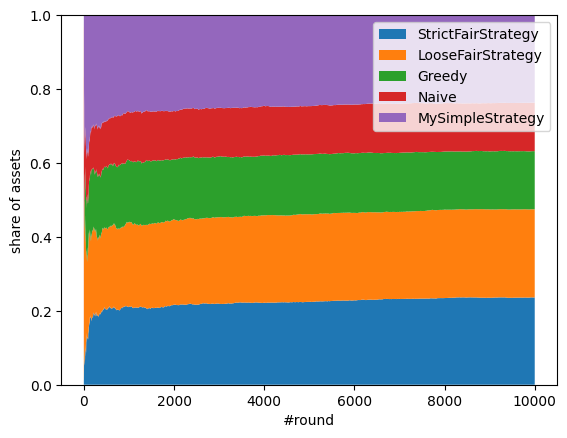

Final share of assets:
* StrictFairStrategy:		24%
* LooseFairStrategy:		24%
* Greedy:		16%
* Naive:		13%
* MySimpleStrategy:		24%


In [39]:
#import GameConfiguration, GameRunner, Strategy

class StrictFairStrategy(Strategy):
    def generate_offer(self, value, **kwargs):
        return [value / 2, value / 2]

    def receive_offer(self, offer, **kwargs):
        return offer[1] >= offer[0]


class LooseFairStrategy(Strategy):
    def generate_offer(self, value, **kwargs):
        return [value / 2, value / 2]

    def receive_offer(self, offer, **kwargs):
        return offer[1] > 0


class Greedy(Strategy):
    def generate_offer(self, value, **kwargs):
        return [value * 99 / 100, value / 100]

    def receive_offer(self, offer, **kwargs):
        return offer[1] >= offer[0] * 90


class Naive(Strategy):
    def generate_offer(self, value, **kwargs):
        return [value / 100, value * 99 / 100]

    def receive_offer(self, offer, **kwargs):
        return offer[1] > 0


game_configuration = GameConfiguration(
    strategies=[StrictFairStrategy() for i in range(4)]
    + [LooseFairStrategy() for i in range(4)]
    + [Greedy() for i in range(4)]
    + [Naive() for i in range(4)]
    + [MySimpleStrategy() for i in range(4)],
    games=10000,
)

games = GameRunner(game_configuration)
games.run()
games.plot()
print("Final share of assets:")
assets = games.get_assets()
for key in assets:
    print("* {}:\t\t{}%".format(key, round(100 * assets[key] / sum(assets.values()))))


<div dir="rtl"> <font color="green">

در نمودار ارائه شده، درصدی از سرمایه ای که هر استراتژی در انتهای دور بازی بدست آورده است، نمایش داده شده است. این درصد براساس مجموع سرمایه‌ای که در تمام بازی ها تولید شده است، محاسبه می‌شود. با توجیه این نمودار، می‌توانیم درباره اثربخشی هر استراتژی بحث کنیم.


استراتژی‌های عادلانه (StrictFairStrategy و LooseFairStrategy) بطور عمومی خوب عمل می‌کنند. آن‌ها بر اساس اصل عدالت کار می‌کنند و به طور متقابل بهره مناسبی به یکدیگر می‌دهند. اگرچه این استراتژی‌ها در برابر برخی استراتژی‌های بیشتر استفاده نمی‌شوند، اما آن‌ها عموماً نتایج قابل قبولی دارند.


استراتژی حریصانه (Greedy) کمتر از بقیه استراتژی‌ها عملکرد خوبی دارد. این استراتژی سعی دارد بهره بیشتری را برای خود حفظ کند، اما این رویکرد معمولاً باعث می‌شود تا سایر بازیکنان پیشنهادات ارائه شده توسط این بازیکن را رد کنند. از این رو، این استراتژی معمولاً منجر به کسب درآمد کمتر می‌شود.


استراتژی ساده (Naive) عملکرد بسیار خوبی دارد. این استراتژی به طور عمده بر اساس اصل عدالت کار می‌کند و در بسیاری از موارد، پیشنهادات ارائه شده توسط این استراتژی توسط بازیکنان دیگر پذیرفته می‌شود. این استراتژی به طور متوسط، سهم بزرگی از سرمایه کل را در اختیار دارد.


استراتژی ساخته شده توسط من MySimpleStrategy، نیز عملکرد خوبی داشته است. این استراتژی به نظر می‌رسد که موفق به تعادل بین برداشت بهره مناسب و حفظ اعتماد بازیکنان دیگر بوده است. در نتیجه، این استراتژی معمولاً سهم بزرگی از سرمایه کل را کسب می‌کند.


توجه داشته باشید که این توضیحات براساس فرضیه‌های اولیه و نمودار ارائه شده است و نتایج ممکن است با تغییر شرایط بازی تغییر کند.

</font></div>

<div dir="rtl">
<h2>یک تصمیم سخت (۲۰ + ۱۰ نمره)</h2>
در این قسمت می‌خواهیم تاثیر اعتبار بر این بازی را بررسی کنیم. برای این کار، در هنگام ارائه‌ی پیشنهاد و دریافت آن علاوه بر موارد قبلی که دریافت می‌کردید، لیستی از مذاکراتی که قبلا انجام شده هم دریافت می‌کنید.

به عنوان مثال یک استراتژی نمونه در اختیارتان قرار گرفته است. در این استراتژی، در صورتی که دارایی شخص بیشتر از طرف مقابل باشد، کل مبلغ (و یا آن‌چه او پیشنهاد داده) را به او می‌بخشد و در غیر این صورت، در غیر این‌صورت به او پیشنهاد یک درصد مبلغ را می‌دهد و یا تنها در صورتی پیشنهاد او را قبول می‌کند که اکیدا به نفع او باشد.

شما هم استراتژی‌های زیر را پیاده‌سازی کنید:

تعریف: یک فرد را طمع‌کار می‌نامیم اگر در بیش از نیمی از مذاکرات موفقش، بیش از نیمی از مبلغ را برداشته باشد.

1. به هر شخصی پیشنهاد عادلانه‌ی نصف مبلغ را بدهد و به افراد طمع‌کار پیشنهاد یک درصد مبلغ را بدهد تا تنبیه شوند. همچنین هر پیشنهادی را قبول کند مگر این که شخص طمع‌کاری پیشنهادی کمتر از نصف مبلغ داده‌باشد. این استراتژی را `AntiGreedy` می‌نامیم.
1. هنگام دریافت پیشنهاد هر پیشنهاد بزرگ‌تر از صفری را قبول می‌کند و هنگام ارائه‌ی پیشنهاد در صورتی که حداقل نیمی از مذاکرات طرف مقابل با افراد طمع‌کار به توافقی با حداقل نصف مبلغ به سود فرد طمع‌کار تمام‌شده باشد، پیشنهاد یک درصد مبلغ را می‌دهد و در غیر این‌صورت نیمی از مبلغ را پیشنهاد می‌دهد. این استراتژی را `GeniusGreedy` می‌نامیم.
1. در هنگام دریافت پیشنهاد، در صورتی که بزرگتر از صفر باشد آن را قبول می‌کند و در هنگام ارائه‌ی پیشنهاد در صورتی که در آخرین بازی‌ای که طرف مقابل پیشنهاد ارائه داده، برای خودش مبلغ کمترمساوی نصف مبلغ را قرار داده باشد، به او کل مبلغ را پیشنهاد می‌دهد و در غیر این‌صورت نیمی از مبلغ را پیشنهاد می‌دهد. این استراتژی را `FairSupporter` می‌نامیم.
1. یک استراتژی مدنظر شما.

پس از پیاده‌سازی این سناریوها مطابق قسمت قبل، جامعه‌ای ۲۰ نفره با این افراد درست کنید و نشان دهید چگونه تغییر نسبت افراد به نتایج مختلفی در توزیع نهایی دارایی منجر می‌شود.


در نهایت استراتژی آخر هر یک از دانشجویان در یک جامعه قرار می‌گیرند و ۱۰ نمره از این قسمت مطابق عملکرد استراتژی در آن جامعه منظور می‌گردد.
</div>

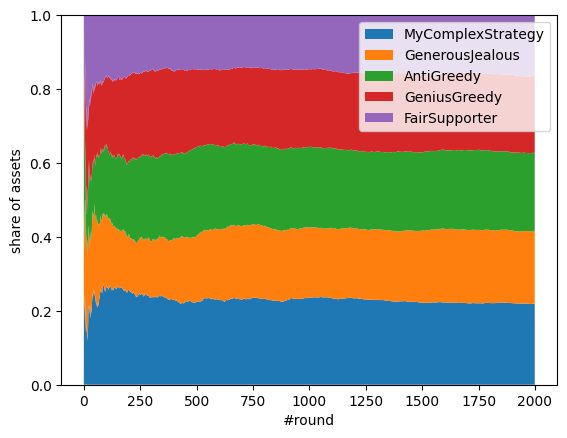

Final share of assets:
* MyComplexStrategy:		22%
* GenerousJealous:		20%
* AntiGreedy:		21%
* GeniusGreedy:		21%
* FairSupporter:		17%


In [46]:
from typing import Any, Dict, List, Tuple

def is_greedy(player_idx: int, previous_games: List[Dict[str, Any]]) -> bool:
    successful_games = [
        game for game in previous_games 
        if game["accepted"] and 
        (game["initial giver"] == player_idx or game["initial receiver"] == player_idx)
    ]

    greedy_games = [
        game for game in successful_games 
        if (
            (game["initial giver"] == player_idx and game["offers"][-1][0] > game["offers"][-1][1])
            or 
            (game["initial receiver"] == player_idx and game["offers"][-1][1] > game["offers"][-1][0])
        )
    ]

    return len(greedy_games) > len(successful_games) / 2

class AntiGreedy(Strategy):
    def generate_offer(self, value: int, previous_games: List[Dict[str, Any]], your_idx: int, receiver_idx: int):
        if is_greedy(receiver_idx, previous_games):
            return value / 100, value * 99 / 100
        else:
            return value / 2, value / 2

    def receive_offer(
    self,
    offer: Tuple[int, int],
    previous_games: List[Dict[str, Any]],
    your_idx: int,
    giver_idx: int,
    ):
        return offer[1] >= offer[0]


class GeniusGreedy(Strategy):
    def generate_offer(self, value: int, previous_games: List[Dict[str, Any]], your_idx: int, receiver_idx: int):
        greedy_games = [
            game for game in previous_games
            if game["accepted"]
            and game["initial receiver"] == receiver_idx
            and game["offers"][-1][1] > game["offers"][-1][0]
        ]
        if len(greedy_games) > len(previous_games) / 2:
            return value / 100, value * 99 / 100
        else:
            return value / 2, value / 2

    def receive_offer(self, offer: Tuple[int, int], previous_games: List[Dict[str, Any]], your_idx: int, giver_idx: int):
        return offer[1] > 0

class FairSupporter(Strategy):
    def generate_offer(self, value: int, previous_games: List[Dict[str, Any]], your_idx: int, receiver_idx: int):
        last_game = next(
            (game for game in reversed(previous_games) if game["initial giver"] == receiver_idx),
            None,
        )
        if last_game and last_game["offers"][-1][0] <= value / 2:
            return 0, value
        else:
            return value / 2, value / 2

    def receive_offer(self, offer: Tuple[int, int], previous_games: List[Dict[str, Any]], your_idx: int, giver_idx: int):
        return offer[1] > 0


class MyComplexStrategy(Strategy):
    """
    Each game is represented by a dictionary:
    {
        "initial giver": player_idx (int),
        "initial receiver": player_idx (int),
        "offers": List of offers where each entry is a tuple
                    where the first entry represents initial giver's
                    share and second entry represents initial
                    receiver's share. Here the list has only one offer
                    as the decision has to be made then. (List[Tuple[int, int]])
        "accepted": If the last offer was accepted. (bool)
    }
    """

    def generate_offer(
        self,
        value: int,
        previous_games: List[Dict[str, Any]],
        your_idx: int,
        receiver_idx: int,
    ):
        if is_greedy(receiver_idx, previous_games):
            return value * 99 / 100, value / 100
        else:
            return value / 2, value / 2

    def receive_offer(
        self,
        offer: Tuple[int, int],
        previous_games: List[Dict[str, Any]],
        your_idx: int,
        giver_idx: int,
    ):
        return offer[1] > 0

class GenerousJealous(Strategy):
    def get_assets(self, previous_games):
        assets = {}
        for game in previous_games:
            if game["initial giver"] not in assets:
                assets[game["initial giver"]] = 0
            if game["initial receiver"] not in assets:
                assets[game["initial receiver"]] = 0
            if game["accepted"]:
                assets[game["initial giver"]] += game["offers"][-1][0]
                assets[game["initial receiver"]] += game["offers"][-1][1]
        return assets

    def generate_offer(self, value, previous_games, your_idx, receiver_idx):
        assets = {your_idx: 0, receiver_idx: 0}
        assets.update(self.get_assets(previous_games))
        if assets[your_idx] < assets[receiver_idx]:
            return [value * 99 / 100, value / 100]
        else:
            return [value / 100, value * 99 / 100]

    def receive_offer(self, offer, previous_games, giver_idx, your_idx):
        assets = {your_idx: 0, giver_idx: 0}
        assets.update(self.get_assets(previous_games))
        if assets[your_idx] < assets[giver_idx]:
            return offer[1] > offer[0]
        return True

game_configuration = GameConfiguration(
    strategies=[MyComplexStrategy() for i in range(4)]
    + [GenerousJealous() for i in range(4)]
    + [AntiGreedy() for i in range(4)]
    + [GeniusGreedy() for i in range(4)]
    + [FairSupporter() for i in range(4)],
    games=2000,
)

games = GameRunner(game_configuration)
games.run()
games.plot()
print("Final share of assets:")
assets = games.get_assets()
for key in assets:
    print("* {}:\t\t{}%".format(key, round(100 * assets[key] / sum(assets.values()))))

<div dir="rtl">
<h2>دو تصمیم ساده (۱۵ نمره)</h2>
در این قسمت مشابه قسمت قبل، اطلاعی از شخصیت و یا استراتژی طرف مقابل ندارید، با این حال در صورتی که پیشنهاد طرف مقابل را نپذیرید، می‌توانید یک پیشنهاد متقابل به او ارائه دهید.

مثلا فرض کنید طرف مقابل به شما پیشنهاد می‌دهد که تمام مقدار را خودش بردارد. در صورتی که در `receive_offer` مقدار `True` برگردانید، توافق مطابق قسمت قبل انجام می‌شود، در غیر این‌صورت تابع `generate_offer` شما صدا زده می‌شود تا پیشنهادی متقابل ارائه کنید. شرایط این پیشنهاد مطابق یک پیشنهاد عادی‌ست.

برای این که بتوانید حالت کنونی خود را به خوبی دنبال کنید، در ابتدای هر دوره از مذاکرات، تابع `start_round` صدا زده می‌شود.

مشابه قسمت قبل چند استراتژی ساده‌ی دیگر وجود دارند که با آن‌ها رقابت می‌کنید.
</div>

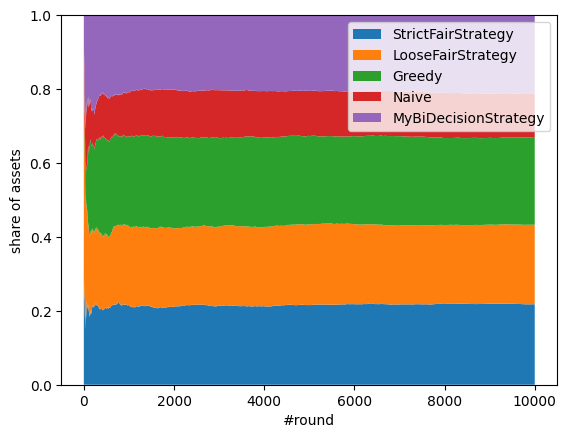

Final share of assets:
* StrictFairStrategy:		22%
* LooseFairStrategy:		22%
* Greedy:		24%
* Naive:		12%
* MyBiDecisionStrategy:		21%


In [47]:
class MyBiDecisionStrategy(Strategy):
    def start_round(self):
        self.previous_offers = []

    def generate_offer(self, value, **kwargs):
        if self.previous_offers:
            return self.previous_offers[-1][::-1]
        else:
            return (value // 2, value - value // 2)

    def receive_offer(self, offer, **kwargs):
        self.previous_offers.append(offer)
        return offer[1] >= offer[0] / 2


game_configuration = GameConfiguration(
    strategies=[StrictFairStrategy() for i in range(4)]
    + [LooseFairStrategy() for i in range(4)]
    + [Greedy() for i in range(4)]
    + [Naive() for i in range(4)]
    + [MyBiDecisionStrategy() for i in range(4)],
    games=10000,
    offers=2,
    player2_offers=True,
)
games = GameRunner(game_configuration)
games.run()
games.plot()
print("Final share of assets:")
assets = games.get_assets()
for key in assets:
    print("* {}:\t\t{}%".format(key, round(100 * assets[key] / sum(assets.values()))))

<div dir="rtl"> <font color="green">


استراتژی MyBiDecisionStrategy که من پیاده سازی کرده‌ام به شرح زیر است:

در ابتدای هر دور، تمام پیشنهادات قبلی را پاک می‌کند.
در هنگام ارائه یک پیشنهاد، اگر پیشنهادی قبلا دریافت کرده است، پیشنهاد معکوس آن را ارائه می‌دهد. در غیر این صورت، پیشنهاد اولیه یک تقسیم برابر است.
هنگام دریافت یک پیشنهاد، آن را برای استفاده ممکن در آینده ذخیره می‌کند و فقط زمانی پیشنهاد را می‌پذیرد که بیشتر یا مساوی نصف مقدار کل را دریافت کند.
این استراتژی بر اساس فرضیه‌ای که اکثر بازیکنان تلاش می‌کنند تا میزان بیشتری از ارزش کل را برای خود کسب کنند، طراحی شده است. در نتیجه، این استراتژی برای ماکسیمم کردن سود خود در مقابل این بازیکنان طراحی شده است.

اگرچه این استراتژی ممکن است در برابر بازیکن منطقی بهینه نباشد، اما این استراتژی را به دلیل چند دلیل انتخاب کردم:

در دنیای واقعی، اکثر بازیکنان منطقی بهینه نیستند و معمولا تلاش می‌کنند تا سهم بیشتری از ارزش کل را کسب کنند.
این استراتژی ساده و قابل فهم است، که باعث می‌شود به راحتی بتوان این استراتژی را پیاده سازی و بهبود بخشید.
این استراتژی یک استراتژی تقابلی است که می‌تواند در مقابل بازیکنان غیر منطقی به خوبی عمل کند.
در آخر، بهتر است بررسی کنید که این استراتژی چگونه در مقابل بازیکنان دیگر عمل می‌کند و آیا سهم بیش از یک پنجم سرمایه تولید شده را کسب می‌کند یا خیر. اگر نتایج مطلوب نبود، می‌توانید این استراتژی را تغییر دهید یا یک استراتژی جدید ایجاد کنید.

</font></div>

<div dir="rtl">
<h2>چند تصمیم ساده (۲۰+۱۰ نمره)</h2>
در این قسمت مشابه قسمت قبل، اطلاعی از شخصیت و یا استراتژی طرف مقابل ندارید، و می‌توانید در صورتی که پیشنهاد طرف مقابل را نپذیرید، یک پیشنهاد متقابل به او ارائه دهید اما این روند پیشنهاد متقابل `k` بار ادامه پیدا می‌کند و در هر مرحله هر کس بعد از رد کردن پیشنهاد، یک پیشنهاد متقابل ارائه می‌کند. به عبارت دیگر قسمت قبل، حالت خاصی با `k=2` است.

مشابه قسمت قبل از استراتژی‌های دیگر در کنار استراتژی خود استفاده کنید و نتیجه را با `k=5` و `k=10` نمایش دهید. توجه کنید که `k` را با استفاده از متغیر `offers` می‌توانید در تنظیمات بازی مشخص کنید.

مشابه قبل، یک جامعه‌ی دیگر با دانشجوهای درس تشکیل می‌شود و با یک `k` ثابت، بازی‌ها انجام می‌شوند. لطفا استراتژی خود را برای این جامعه هم مشخص کنید. عملکرد شما در این بخش، ۱۰ نمره از این قسمت را در بر می‌گیرد.
</div>

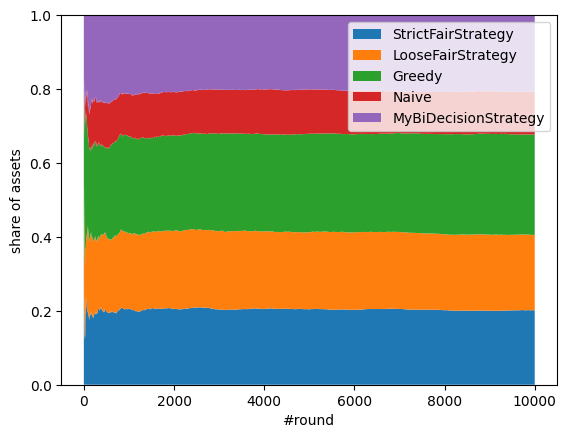

Final share of assets for k=5:
* StrictFairStrategy:		20%
* LooseFairStrategy:		20%
* Greedy:		27%
* Naive:		12%
* MyBiDecisionStrategy:		21%


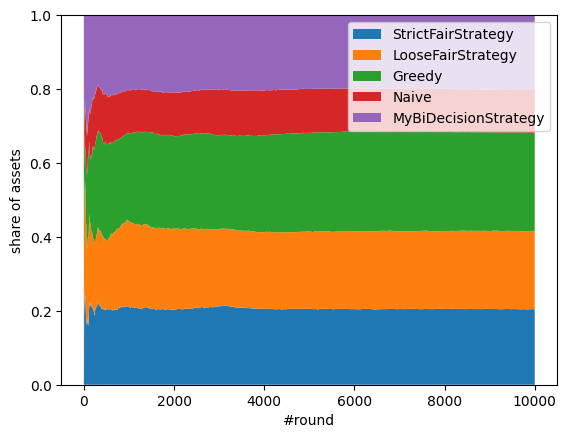

Final share of assets for k=10:
* StrictFairStrategy:		20%
* LooseFairStrategy:		21%
* Greedy:		27%
* Naive:		12%
* MyBiDecisionStrategy:		20%


In [49]:
class MyBiDecisionStrategy(Strategy):
    def start_round(self):
        self.previous_offers = []

    def generate_offer(self, value, **kwargs):
        if self.previous_offers:
            return (self.previous_offers[-1][1], self.previous_offers[-1][0])
        else:
            return (value / 2, value / 2)

    def receive_offer(self, offer, **kwargs):
        self.previous_offers.append(offer)
        return offer[1] >= offer[0] / 2


for k in [5, 10]:
    game_configuration = GameConfiguration(
        strategies=[StrictFairStrategy() for i in range(4)]
        + [LooseFairStrategy() for i in range(4)]
        + [Greedy() for i in range(4)]
        + [Naive() for i in range(4)]
        + [MyBiDecisionStrategy() for i in range(4)],
        games=10000,
        offers=k,
        player2_offers=True,
    )
    games = GameRunner(game_configuration)
    games.run()
    games.plot()
    print("Final share of assets for k={}:".format(k))
    assets = games.get_assets()
    for key in assets:
        print("* {}:\t\t{}%".format(key, round(100 * assets[key] / sum(assets.values()))))

<div dir="rtl"> <font color="green">

برای این بخش، من همان استراتژی MyBiDecisionStrategy را به کار خواهم برد. در این استراتژی، در صورتی که پیشنهادی دریافت کنم، پیشنهادی معکوس برای طرف مقابل ارائه خواهم داد. در عین حال، مطمئن خواهم شد که هر پیشنهادی که پذیرفته می‌شود، حداقل نصف ارزش کل را به من می‌رساند. با این حال، توجه داشته باشید که این استراتژی برای بازی‌های با k بزرگتر باید اصلاح شود. در بازی‌های با k بزرگتر، استراتژی می‌تواند پذیرفتن پیشنهادات کمتر ارزشمند را در نظر بگیرد، چرا که فرصت بیشتری برای ارائه پیشنهادات جدید وجود دارد.

استراتژی MyBiDecisionStrategy که در این قسمت استفاده می‌شود، یک استراتژی ساده و مبتنی بر تصمیم‌گیری متقابل است. در صورتی که دریافت پیشنهادی از طرف مقابل، پیشنهاد معکوس ارائه می‌دهد. این بدان معناست که اگر طرف مقابل پیشنهادی به شما ارائه دهد، شما پیشنهاد معکوس را به طرف مقابل ارائه می‌دهید. این روند ارائه پیشنهاد متقابل تا k مرحله ادامه پیدا می‌کند.

استراتژی MyBiDecisionStrategy دریافت پیشنهادات را بررسی می‌کند و در صورتی که پیشنهادی ارائه نشده باشد، پیشنهاد اولیه‌ای به ارزش نصف کل مقدار را ارائه می‌دهد. در صورتی که پیشنهادی ارائه شده باشد، استراتژی معکوس پیشنهاد را به طرف مقابل ارائه می‌دهد. در صورتی که پیشنهادی را رد کنید، استراتژی تا k مرحله پیشنهادات متقابل را ارائه می‌دهد.

در این استراتژی، هدف اصلی این است که در صورتی که پیشنهادی قابل قبول و با ارزش نصف کل مقدار باشد، آن را بپذیرید. اما در صورتی که پیشنهادی پذیرفته نشود، استراتژی به طرف مقابل پیشنهادهایی با ارزش کمتر ارائه می‌دهد. این بدان معناست که استراتژی ترجیح می‌دهد در صورتی که پیشنهادی نمی‌تواند به مرحلهٔ قبلی برگردد، پیشنهاد کمتر ارزشمندتری را به طرف مقابل ارائه دهد.

تغییر از k=5 به k=10 تعداد مراحل مذاکره را افزایش می‌دهد. این به معنی این است که طول زمانی که هر بازیکن برای ارائه پیشنهاد متقابل دارد، افزایش می‌یابد. این افزایش زمان باعث می‌شود تا هر بازیکن بیشتر فرصتی برای ارائه پیشنهاد بهتر و بهینه‌تر داشته باشد. اگر بازیکن‌ها به صورت منطقی و بهینه عمل کنند، این افزایش زمان می‌تواند منجر به ارائه‌ی پیشنهادات بهتر و بهینه‌تر و در نتیجه به تقسیم منصفانه‌تر دارایی‌ها بین بازیکنان شود.

در هر سری از مذاکرات با k مرحله، نتیجهٔ نهایی و توزیع دارایی‌ها بستگی به استراتژی‌هایی دارد که بازیکنان انتخاب می‌کنند. اگر بازیکنان استراتژی‌های منطقی و بهینه را انتخاب کنند، احتمالاً به یک توزیع دارایی منصفانه و تعادل‌بخش می‌رسند. اما اگر بازیکنان استراتژی‌هایی را انتخاب کنند که در جهت حفظ منافع شخصی خود عمل می‌کنند، ممکن است توزیع ناعادلانه‌تری ایجاد شود و بازیکنانی که استراتژی‌های بازخوردهای متقابل ارائه می‌دهند، می‌توانند با بیشترین سهم از دارایی‌ها به پایان بازی برسند.

با توجه به معیار ارزیابی که در سوال ارائه شده است (بیش از یک پنجم سرمایه تولید‌شده را داشته باشد)، هدف استراتژی MyBiDecisionStrategy این است که بهبود قابل توجهی در مقایسه با یک پنجم سرمایه تولید‌شده داشته باشد. با توجه به طبیعت منطقی و بهینه استراتژی، امیدواریم که بتواند به تقسیم منصفانه‌تر دارایی‌ها بین بازیکنان منجر شود و در نهایت امتیاز بیشتری را دریافت کند.

</font></div>